In [1]:
import warnings
import random
import math
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import scale, StandardScaler, Imputer
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from IPython.display import Image
init_notebook_mode(connected=True)

pd.set_option("display.max_colwidth", 1000, "display.max_columns", None)
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
mpl.rcParams["figure.dpi"] = 100

# 什么是机器学习

Wikepida: Machine learning is a field of artificial intelligence that uses **statistical** techniques to give computer systems the ability to **learn from data**, **without being explicitly programmed**.

Tom Mitchell: A computer program is said to learn from **experience E** with respect to some class of **tasks T** and **performance measure P** if its performance at tasks in T, as measured by P, improves with experience E.

![compare](tranditional_ml.png)

# 为什么需要机器学习

- 个性化
- 知识挖掘
- 单调任务自动化
- ...










# 机器学习工作流

1. 指标定义（功能改进、新功能、新产品）
2. 数据获取
3. 数据准备（清洗、标注）
4. 模型构建
5. 模型评估
6. 模型部署

_迭代的过程_

![workflow](ml_workflow.png)

## 数据获取

### 需要什么样的数据？
  - 已有数据
  - 开源数据
  - 爬虫
  - 第三方合作

![data_sources](data_sources.png)

### 需要多少数据？

#### 大数定理

In [3]:
np.random.seed(1)
p = 0.7 # 真实的正面向上的概率
trial_count = 1000
sizes = np.arange(1, trial_count)
rand_v = stats.bernoulli(p)
samples = [rand_v.rvs(size) for size in sizes]
estimated_p = [np.sum(sample)/len(sample) for sample in samples]

In [4]:
trace_0 = go.Scatter(x = sizes, y = estimated_p, mode = "lines", name = "估计的p值")
trace_1 = go.Scatter(x = sizes, y = np.full(trial_count, p), mode = "lines", name = f"真实的p值：{p}")
data = [trace_0, trace_1]
layout = go.Layout(
    xaxis = dict(title = "投掷次数（样本数）"),
    yaxis = dict(title = "正面向上的频率")
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### 学习曲线

In [5]:
def plot_learning_curve(model, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # 两个方差之内的区域
    p1 = go.Scatter(x=train_sizes, y=test_scores_mean+test_scores_std, mode="lines", 
                    line=dict(color="blue", width=1), showlegend=False)
    p2 = go.Scatter(x=train_sizes, y=test_scores_mean-test_scores_std, mode="lines",
                    line=dict(color="blue", width=1), showlegend=False, fill="tonexty")
    p3 = go.Scatter(x=train_sizes, y=train_scores_mean+train_scores_std, mode="lines",
                    line=dict(color="red", width=1), showlegend=False)
    p4 = go.Scatter(x=train_sizes, y=train_scores_mean-train_scores_std, mode="lines",
                    line=dict(color="red", width=1), showlegend=False, fill="tonexty")
    # 均值
    p5 = go.Scatter(x=train_sizes, y=test_scores_mean, marker=dict(color="blue"),
                    name="cross validation score", showlegend=True)
    p6 = go.Scatter(x=train_sizes, y=train_scores_mean, marker=dict(color="red"),
                    name="training score", showlegend=True)
    data = [p1, p2, p3, p4, p5, p6]
    layout = go.Layout(
        title = "learning curve",
        xaxis = dict(title = "training size"),
        yaxis = dict(title = "score")
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [6]:
digits = load_digits()
# print(digits["DESCR"])
X, y = digits.data, digits.target
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
model = SVC(gamma=0.001)
plot_learning_curve(model, X, y, cv=cv, n_jobs=8)

#### 一些参考方法

- 参考相似问题的解决方案

  例如论文
  
  
- 根据特征数量、分类个数等估算

  每一个分类都应该有足量的独立样本
  
  每引入一个新的特征，需要更多百分比的样本
  
  
- 模型越复杂，需要的数据一般越多

  例如对应每个模型参数，应该有若干个独立的样本
  
  
- 寻求领域专家的建议

  哪些数据、多少数据才能囊括真实世界中变量间的关系

## 数据准备

据统计，数据准备过程一般要占数据挖掘项目的40%-70%的时间，在某些复杂的项目中占用的时间甚至为总项目时间的80%

- 数据清洗

  空字段、错误格式、离群值（outlier）、重复数据等
  
  
- 数据标注（annotation）

  
- 数字化

  分类变量（categorical variable）、embedding等
  
  
- 特征缩放（feature scaling）

  归一化（normalization）、标准化（standardization）等
  
  
- 特征工程（feature engineering）

## 模型构建

### 什么是模型

![解释模型](whatsamodel.png "模型")

### 机器学习的类型

#### 有监督学习（supervised learning）

  所有数据中包括需要预测的输出。（全部是标注数据）
  
  ![supervised](supervised.png)
  

In [9]:
pd.DataFrame({"建筑面积": [200, 100, 80, 150, 120], "卧室数量": [5, 3, 2, 3, 3], "卫生间数量": [2, 1, 1, 2, 2], 
              "楼层": [3, 20, 2, 6, 15], "价格": [386, 223, 180, 260, "???"]})

建筑面积  卧室数量  卫生间数量  楼层   价格
0   200     5      2   3  386
1   100     3      1  20  223
2    80     2      1   2  180
3   150     3      2   6  260
4   120     3      2  15  ???

#### 无监督学习（unsupervised learning）

数据中没有需要预测的输出。（无标注的数据）

- 关联规则
- 降维
- 聚类
- 主题模型
- 社区发现
- ...
  
![unsupervised](unsupervised.png)

In [7]:
mall_customers = pd.read_csv("Mall_Customers.csv")

In [8]:
mall_customers.head(5)

CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a25711cf8>,
      dtype=object)

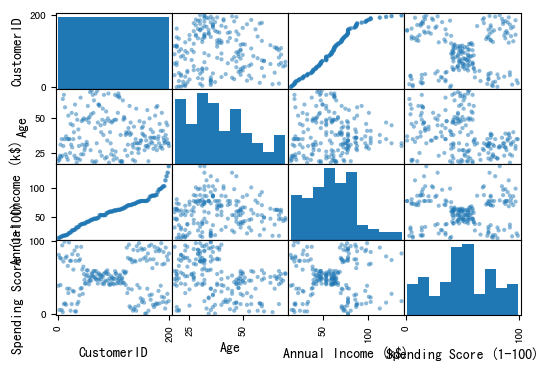

In [9]:
pd.scatter_matrix(mall_customers)

In [10]:
X = mall_customers.iloc[:, [3, 4]].values

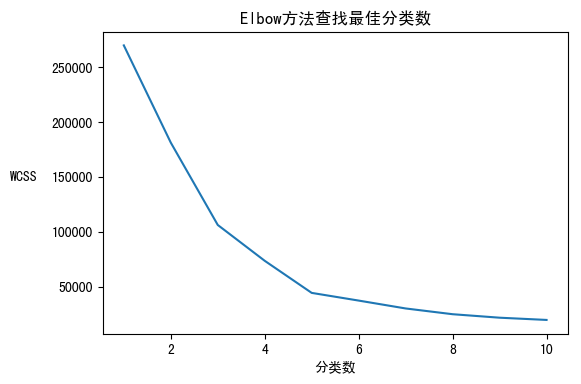

In [11]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = "k-means++")
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title("Elbow方法查找最佳分类数")
plt.xlabel("分类数")
plt.ylabel("WCSS", rotation=0, labelpad=20)
plt.show()

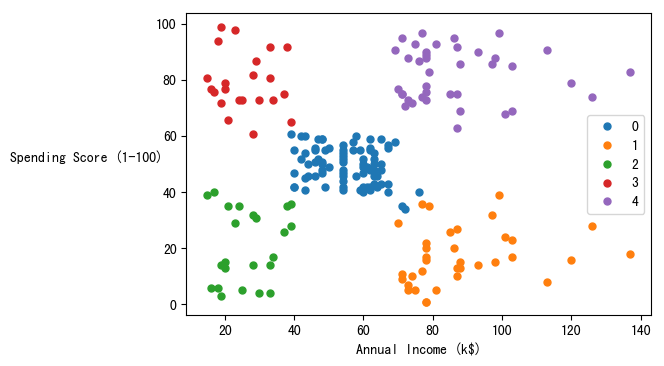

In [12]:
kmeans = KMeans(n_clusters=5, init="k-means++").fit(X)
mall_customers["clusters"] = kmeans.labels_
groups = mall_customers.groupby("clusters")
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group["Annual Income (k$)"], group["Spending Score (1-100)"], marker="o", linestyle="", ms=5, label=name)
ax.set_xlabel("Annual Income (k$)")
ax.set_ylabel("Spending Score (1-100)", rotation=0, labelpad=50)
ax.legend()

In [13]:
mall_customers.sample(5)

CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
54           55  Female   50                  43                      45   
57           58    Male   69                  44                      46   
116         117  Female   63                  65                      43   
118         119  Female   51                  67                      43   
75           76    Male   26                  54                      54   

     clusters  
54          0  
57          0  
116         0  
118         0  
75          0

#### 强化学习（reinforcement learning）

  主体（agent）通过与周围环境（environment）的交互来进行学习。主体每采取一次动作（action）会得到相应的数值奖励（numerical reward）。学习的目标是通过执行一系列的动作使累积奖励（accumulated reward）最大化。

##### 随机选取

In [14]:
# 模拟数据
ads_df = pd.read_csv("Ads_CTR_Optimisation.csv")
ads_df.head()

Ad 1  Ad 2  Ad 3  Ad 4  Ad 5  Ad 6  Ad 7  Ad 8  Ad 9  Ad 10
0     1     0     0     0     1     0     0     0     1      0
1     0     0     0     0     0     0     0     0     1      0
2     0     0     0     0     0     0     0     0     0      0
3     0     1     0     0     0     0     0     1     0      0
4     0     0     0     0     0     0     0     0     0      0

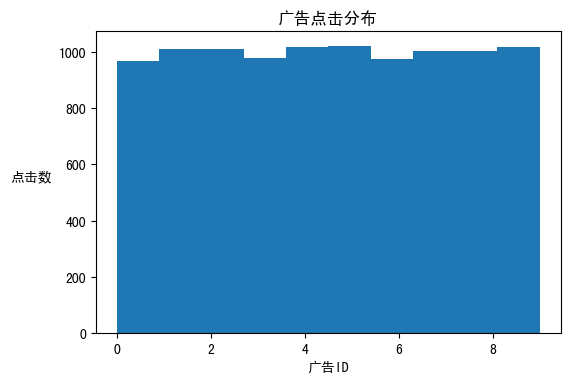

点击命中总数1255


In [16]:
N = ads_df.shape[0]
d = ads_df.shape[1]
ads_selected = []
total_reward = 0
for n in range(0, N):
    ad = random.randrange(d)
    ads_selected.append(ad)
    reward = ads_df.values[n, ad]
    total_reward = total_reward + reward
    
plt.hist(ads_selected)
plt.title("广告点击分布")
plt.xlabel('广告ID')
plt.ylabel('点击数', rotation=0, labelpad=20)
plt.show()
print(f"点击命中总数{total_reward}")

##### UCB

https://en.wikipedia.org/wiki/Multi-armed_bandit

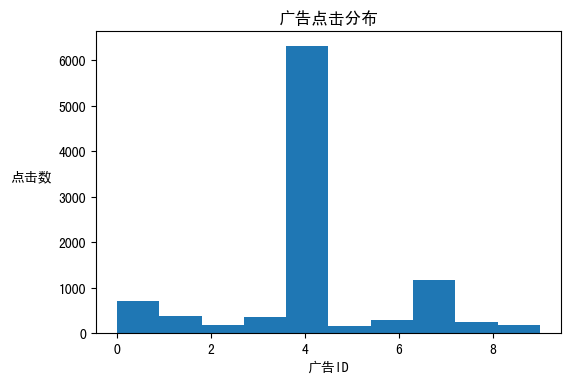

点击命中总数2178


In [17]:
ads_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d
total_reward = 0
for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i
    ads_selected.append(ad)
    numbers_of_selections[ad] = numbers_of_selections[ad] + 1
    reward = ads_df.values[n, ad]
    sums_of_rewards[ad] = sums_of_rewards[ad] + reward
    total_reward = total_reward + reward

plt.hist(ads_selected)
plt.title("广告点击分布")
plt.xlabel('广告ID')
plt.ylabel('点击数', rotation=0, labelpad=20)
plt.show()
print(f"点击命中总数{total_reward}")

### 构建过程

![building](building.png)

#### 什么是特征工程？

特征：原始数据的数字表示

特征工程：根据数据、模型以及目标制定最适合的特征

#### 数据集分割

交叉验证

![cross_validation](cross_validation.png)

#### 训练过程

##### 梯度下降

梯度定义：
$$f({x_1},{x_2},...,{x_n}) = \nabla f = \left[ {{\partial  \over {\partial {x_1}}},{\partial  \over {\partial {x_2}}},...,{\partial  \over {\partial {x_n}}}} \right]$$

梯度是损失函数$J(\theta )$的梯度，$\theta$是模型的参数

例如一个回归模型为${h_\theta }({x_i}) \to {y_i}$，那么损失函数可以定义为
$$J(\theta ) = {1 \over m}\sum\limits_{i = 1}^m {{{({h_\theta }({x^i}) - {y^i})}^2}} $$

则梯度下降的过程为
$$\theta  \leftarrow \theta  - \eta {{\partial J(\theta )} \over {\partial \theta }}$$



![gradient_descent](gradient_descent.png)

![gradient_descent_animation](gradient_descent_animation.gif)

##### 过拟合

![overfit](overfit.png)

# 应用

## 医疗

- 结节良恶性判定（分类）
- 癌症并发症风险预测（分类）
- 疾病复发预测（分类）
- 癌症生存期预测（回归）
- 疾病亚型发现及精确医疗（聚类）
- 医学影像分析（分类）
- ...

## 保险

- 智能核保（分类）
- 保险个性化推荐（分类、聚类）
- 风控、反欺诈（分类、聚类）
- 保险定价（回归）
- 被保人审核（人脸识别、语音识别）（分类）
- ...

# 示例

In [18]:
def try_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"training score: {training_score}")
    print(f"test score: {test_score}")
    predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    print(f"accuracy: {accuracy}")
    cm = confusion_matrix(y_test, predicted)
    conf_matrix = pd.DataFrame(data=cm, columns=["预测:否", "预测:是"], index=["实际:否", "实际:是"])
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
    
    TN = cm[0,0] # true negative
    TP = cm[1,1] # true positive
    FN = cm[1,0] # false negative
    FP = cm[0,1] # false positive
    # print(f"TN: {TN}, TP: {TP}, FN: {FN}, FP, {FP}") 
    
    y_pred_prob_yes = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("FP")
    plt.ylabel("TP")
    plt.grid(True)
    
    print(f"auc: {auc(fpr, tpr)}")
    print(f"false positive: {FP}, total positive: {FP+TN}, false positive rate: {FP/(FP+TN)}")
    print(f"false negative: {FN}, total negative: {FN+TP}, false negative rate: {FN/(FN+TP)}")
    
    return model, fpr, tpr

## 乳腺结节风险预测

In [19]:
cancer_df = pd.read_csv("data.csv")

In [20]:
# diagnosis M: 恶性  B: 良性
cancer_df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           184.60      2019.0            0.1622             0.6656   
1           158.80      1956.0            0.1238             0.1866   
2           152.50      1709.0            0.1444             0.4245   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.7119                0.2654          0.4601   
1           0.2416                0.1860          0.2750   
2           0.4504                0.2430          0.3613   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN

In [21]:
y = cancer_df["diagnosis"].map({
    "M": 0,
    "B": 1
})

In [22]:
X = cancer_df.drop(["id", "diagnosis", "Unnamed: 32"], axis=1)

良性样本数: 357
恶性样本数: 212


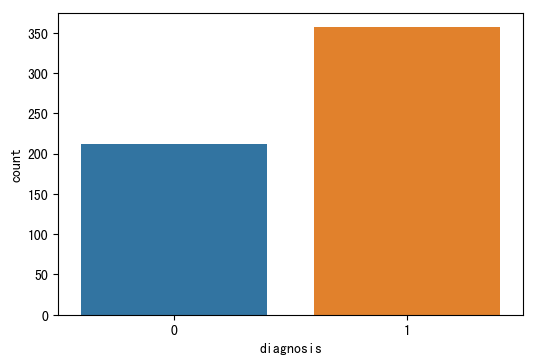

In [23]:
ax = sns.countplot(y, label="Count")
B, M = y.value_counts()
print(f"良性样本数: {B}")
print(f"恶性样本数: {M}")

In [24]:
X.describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean   radius_se  texture_se  \
count     569.000000              569.000000  569.000000  569.000000   
mean        0.181162                0.062798    0.405172    1.216853   
std         0.027414                0.007060    0.277313    0.551648   
min         0.106000                0.049960    0.111500    0.360200   
25%         0.161900                0.057700    0.232400    0.833900   
50%         0.179200                0.061540    0.324200    1.108000   
75%         0.195700                0.066120    0.478900    1.474000   
max         0.304000                0.097440    2.873000    4.885000   

       perimeter_se     area_se  smoothness_se  compactness_se  concavity_se  \
count    569.000000  569.000000     569.000000      569.000000    569.000000   
mean       2.866059   40.337079       0.007041        0.025478      0.031894   
std        2.021855   45.491006       0.003003        0.017908      0.030186   
min        0.757000    6.802000       0.001713        0.002252      0.000000   
25%        1.606000   17.850000       0.005169        0.013080      0.015090   
50%        2.287000   24.530000       0.006380        0.020450      0.025890   
75%        3.357000   45.190000       0.008146        0.032450      0.042050   
max       21.980000  542.200000       0.031130        0.135400      0.396000   

       concave points_se  symmetry_se  fractal_dimension_se  radius_worst  \
count         569.000000   569.000000            569.000000    569.000000   
mean            0.011796     0.020542              0.003795     16.269190   
std             0.006170     0.008266              0.002646      4.833242   
min             0.000000     0.007882              0.000895      7.930000   
25%             0.007638     0.015160              0.002248     13.010000   
50%             0.010930     0.018730              0.003187     14.970000   
75%             0.014710     0.023480              0.004558     18.790000   
max             0.052790     0.078950              0.029840     36.040000   

       texture_worst  perimeter_worst   area_worst  smoothness_worst  \
count     569.000000       569.000000   569.000000        569.000000   
mean       25.677223       107.261213   880.583128          0.132369   
std         6.146258        33.602542   569.356993          0.022832   
min        12.020000        50.410000   185.200000          0.071170   
25%        21.080000        84.110000   515.300000          0.116600   
50%        25.410000        97.660000   686.500000          0.131300   
75%        29.720000       125.400000  1084.000000          0.146000   
max        49.540000       251.200000  4254.000000 

In [25]:
data_std = (X - X.mean())/(X.std())

### 数据可视化

特征分离度，特征相似性...

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

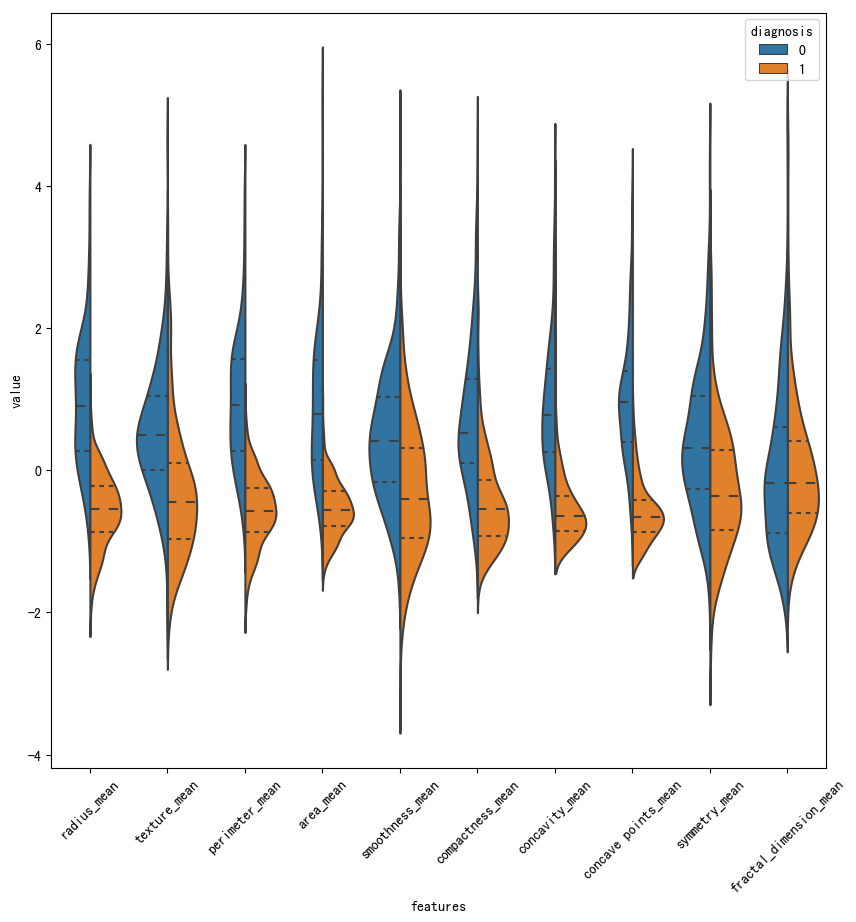

In [26]:
data = pd.concat([y, data_std.iloc[:, 0:10]], axis=1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name="value")
plt.figure(figsize=(10, 10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data, split=True, inner="quart")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

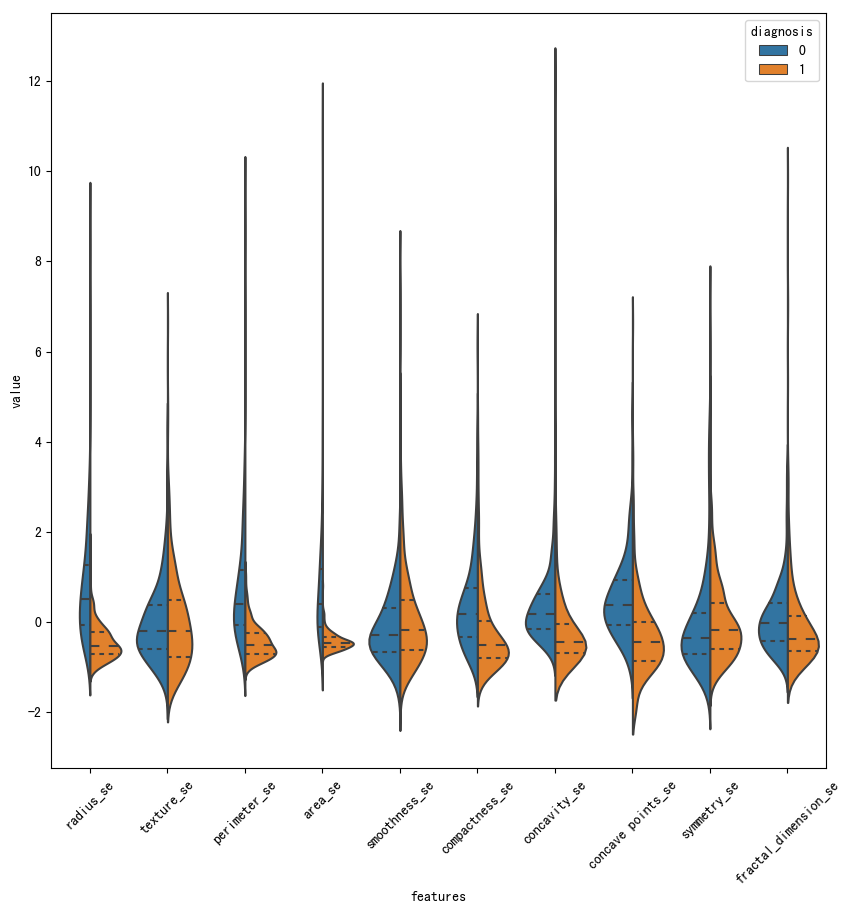

In [27]:
data = pd.concat([y, data_std.iloc[:, 10:20]], axis=1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name="value")
plt.figure(figsize=(10, 10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data, split=True, inner="quart")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

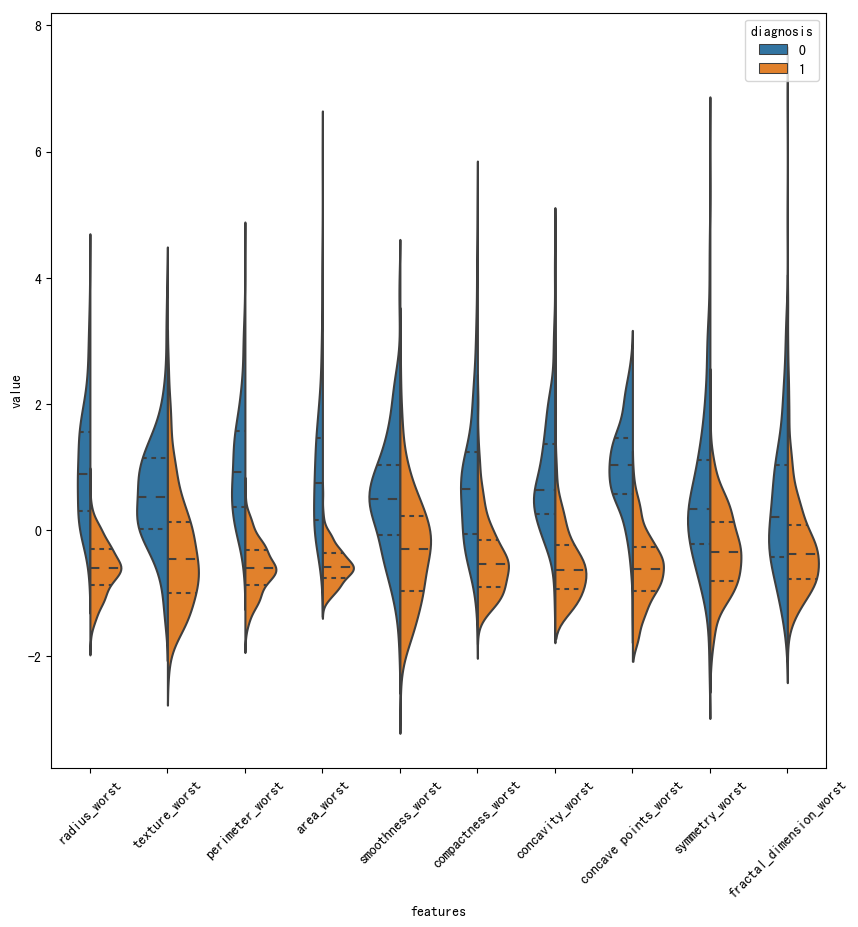

In [28]:
data = pd.concat([y, data_std.iloc[:, 20:]], axis=1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name="value")
plt.figure(figsize=(10, 10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data, split=True, inner="quart")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

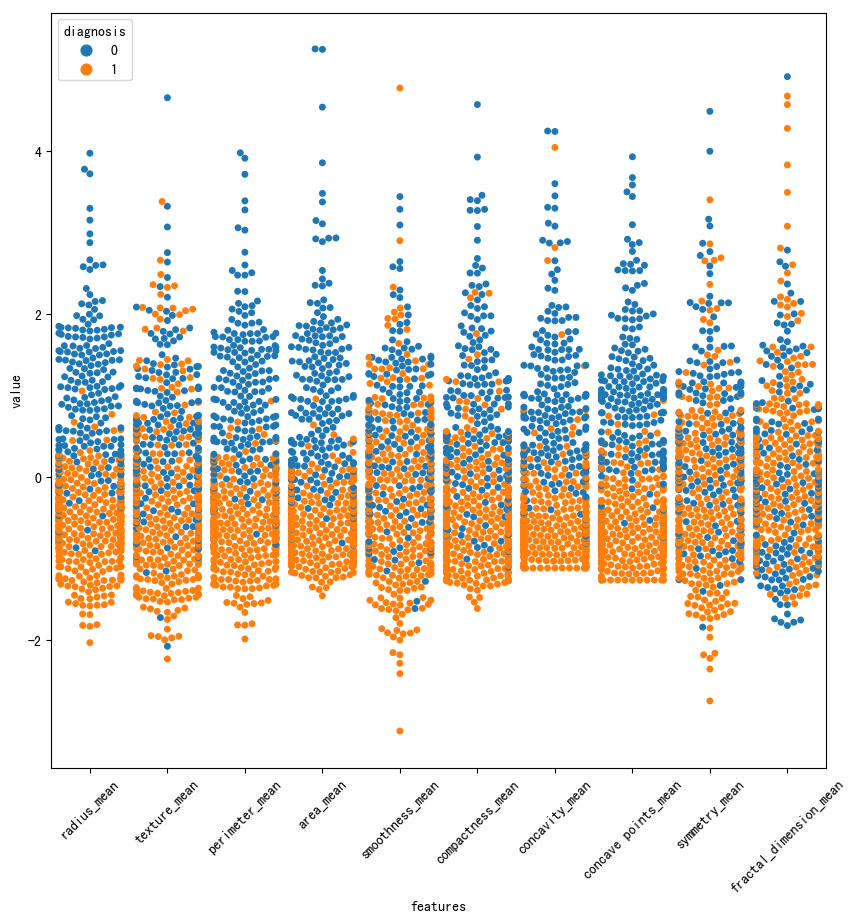

In [29]:
data = pd.concat([y, data_std.iloc[:, 0:10]], axis=1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name="value")
plt.figure(figsize=(10, 10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

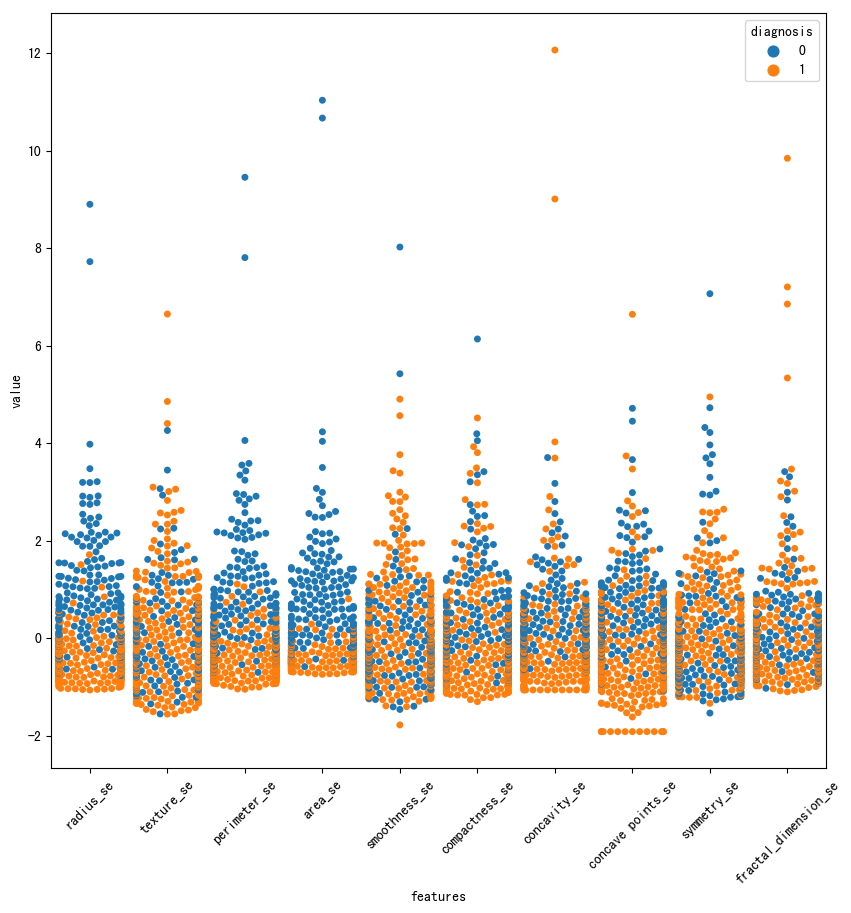

In [30]:
data = pd.concat([y, data_std.iloc[:, 10:20]], axis=1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name="value")
plt.figure(figsize=(10, 10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

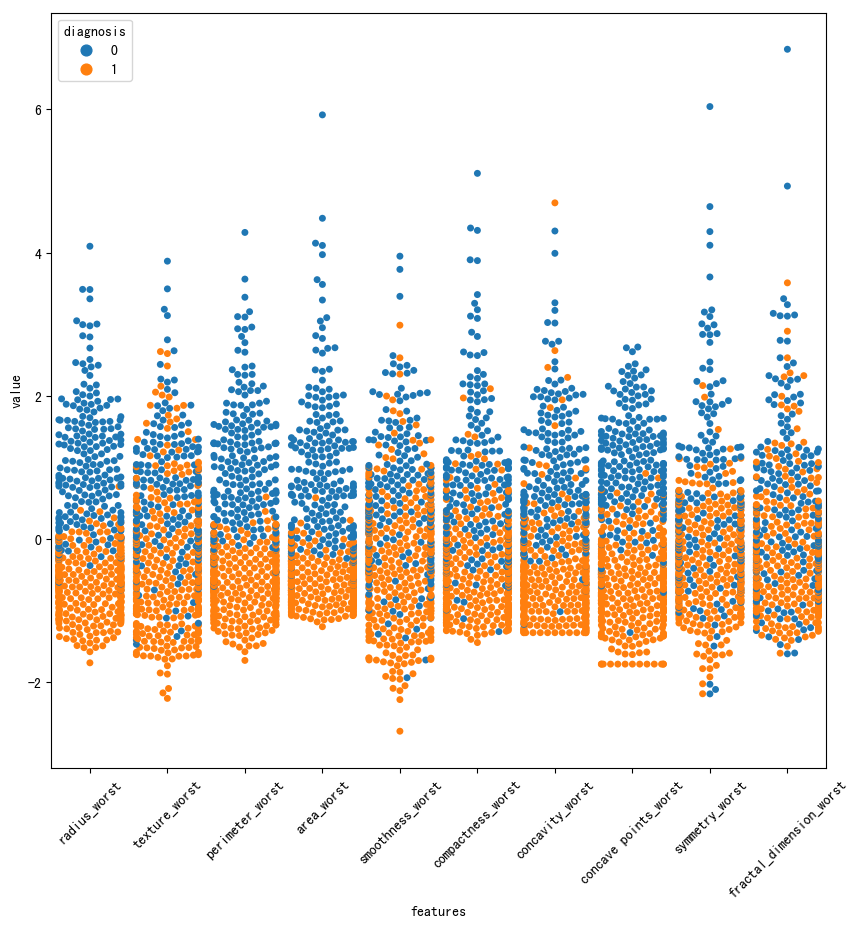

In [31]:
data = pd.concat([y, data_std.iloc[:, 20:]], axis=1)
data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name="value")
plt.figure(figsize=(10, 10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
plt.xticks(rotation=45)

### 特征相关性分析

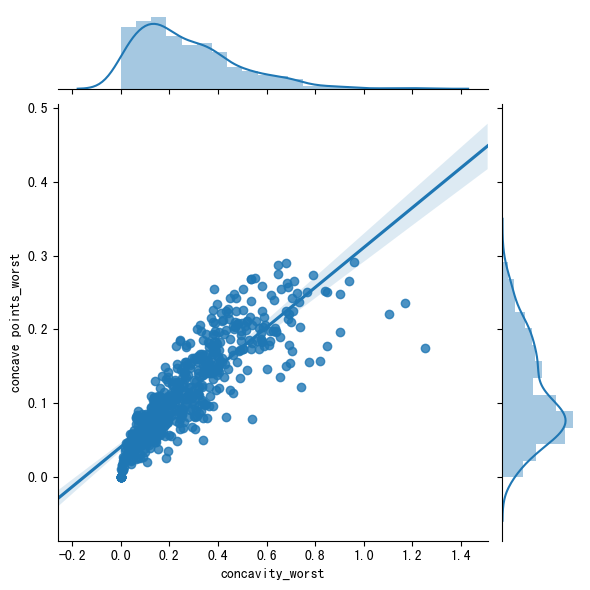

In [32]:
sns.jointplot(
    X.loc[:,'concavity_worst'], 
    X.loc[:,'concave points_worst'], 
    kind="regg"
)

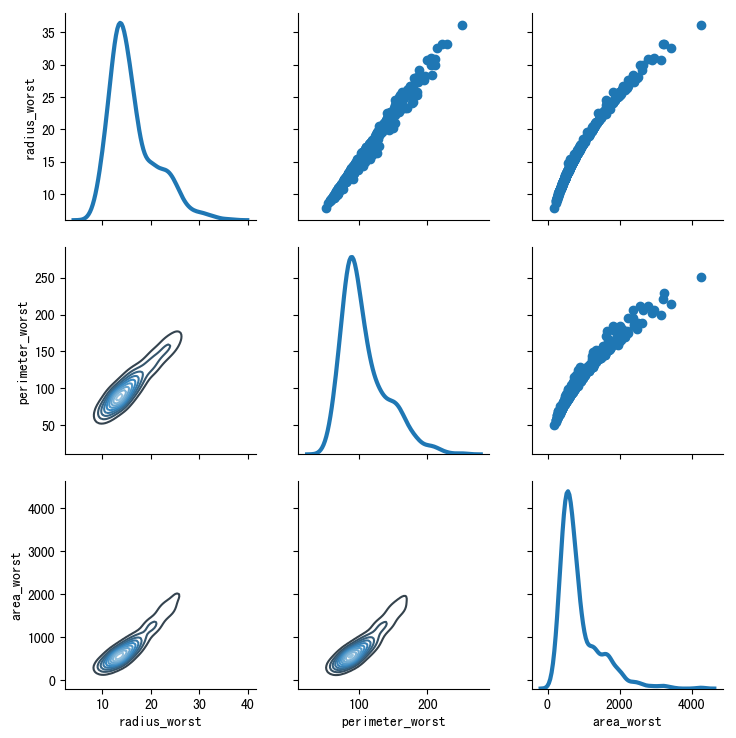

In [33]:
df = X.loc[:,['radius_worst','perimeter_worst','area_worst']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

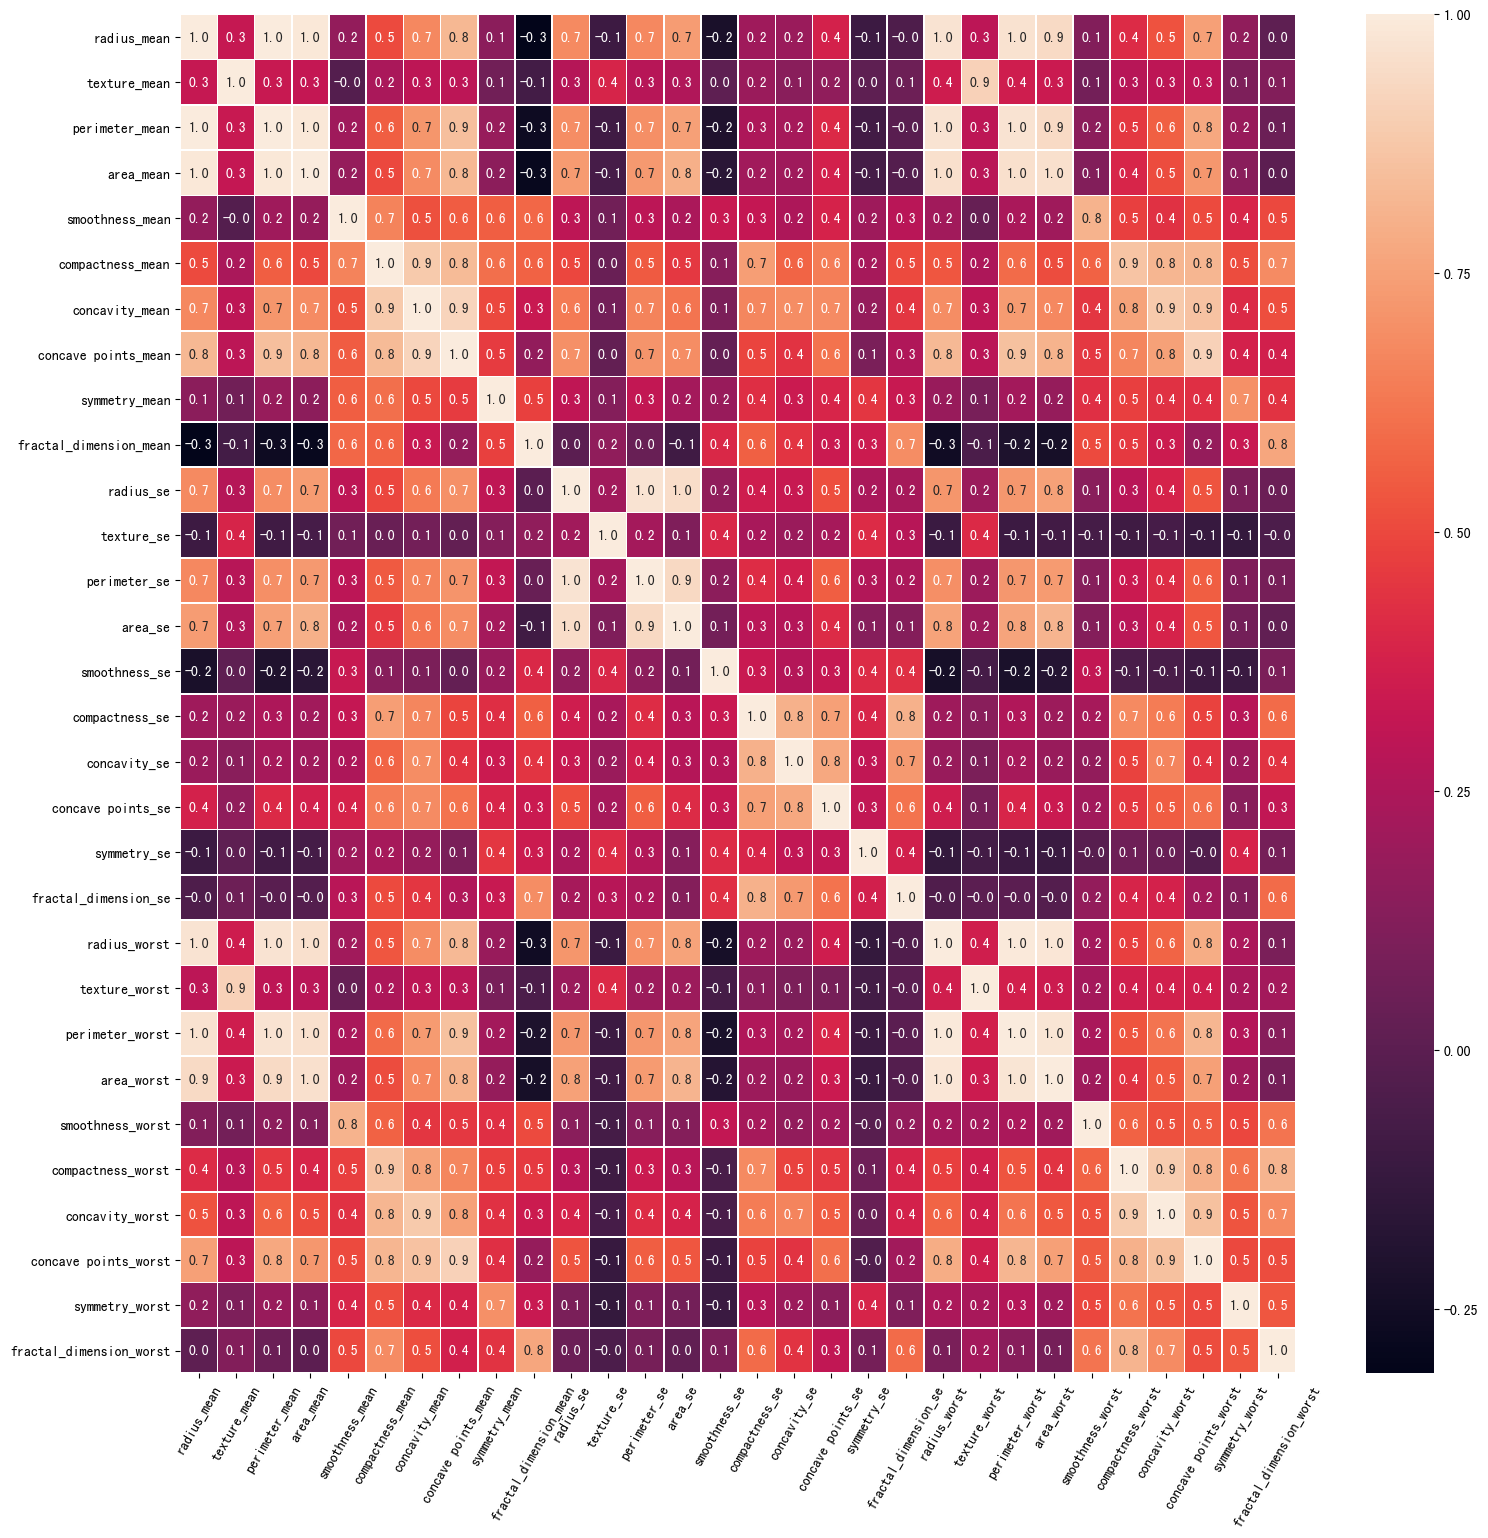

In [34]:
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.xticks(rotation=60)
plt.show()

### 基于相关性分析的特征选择

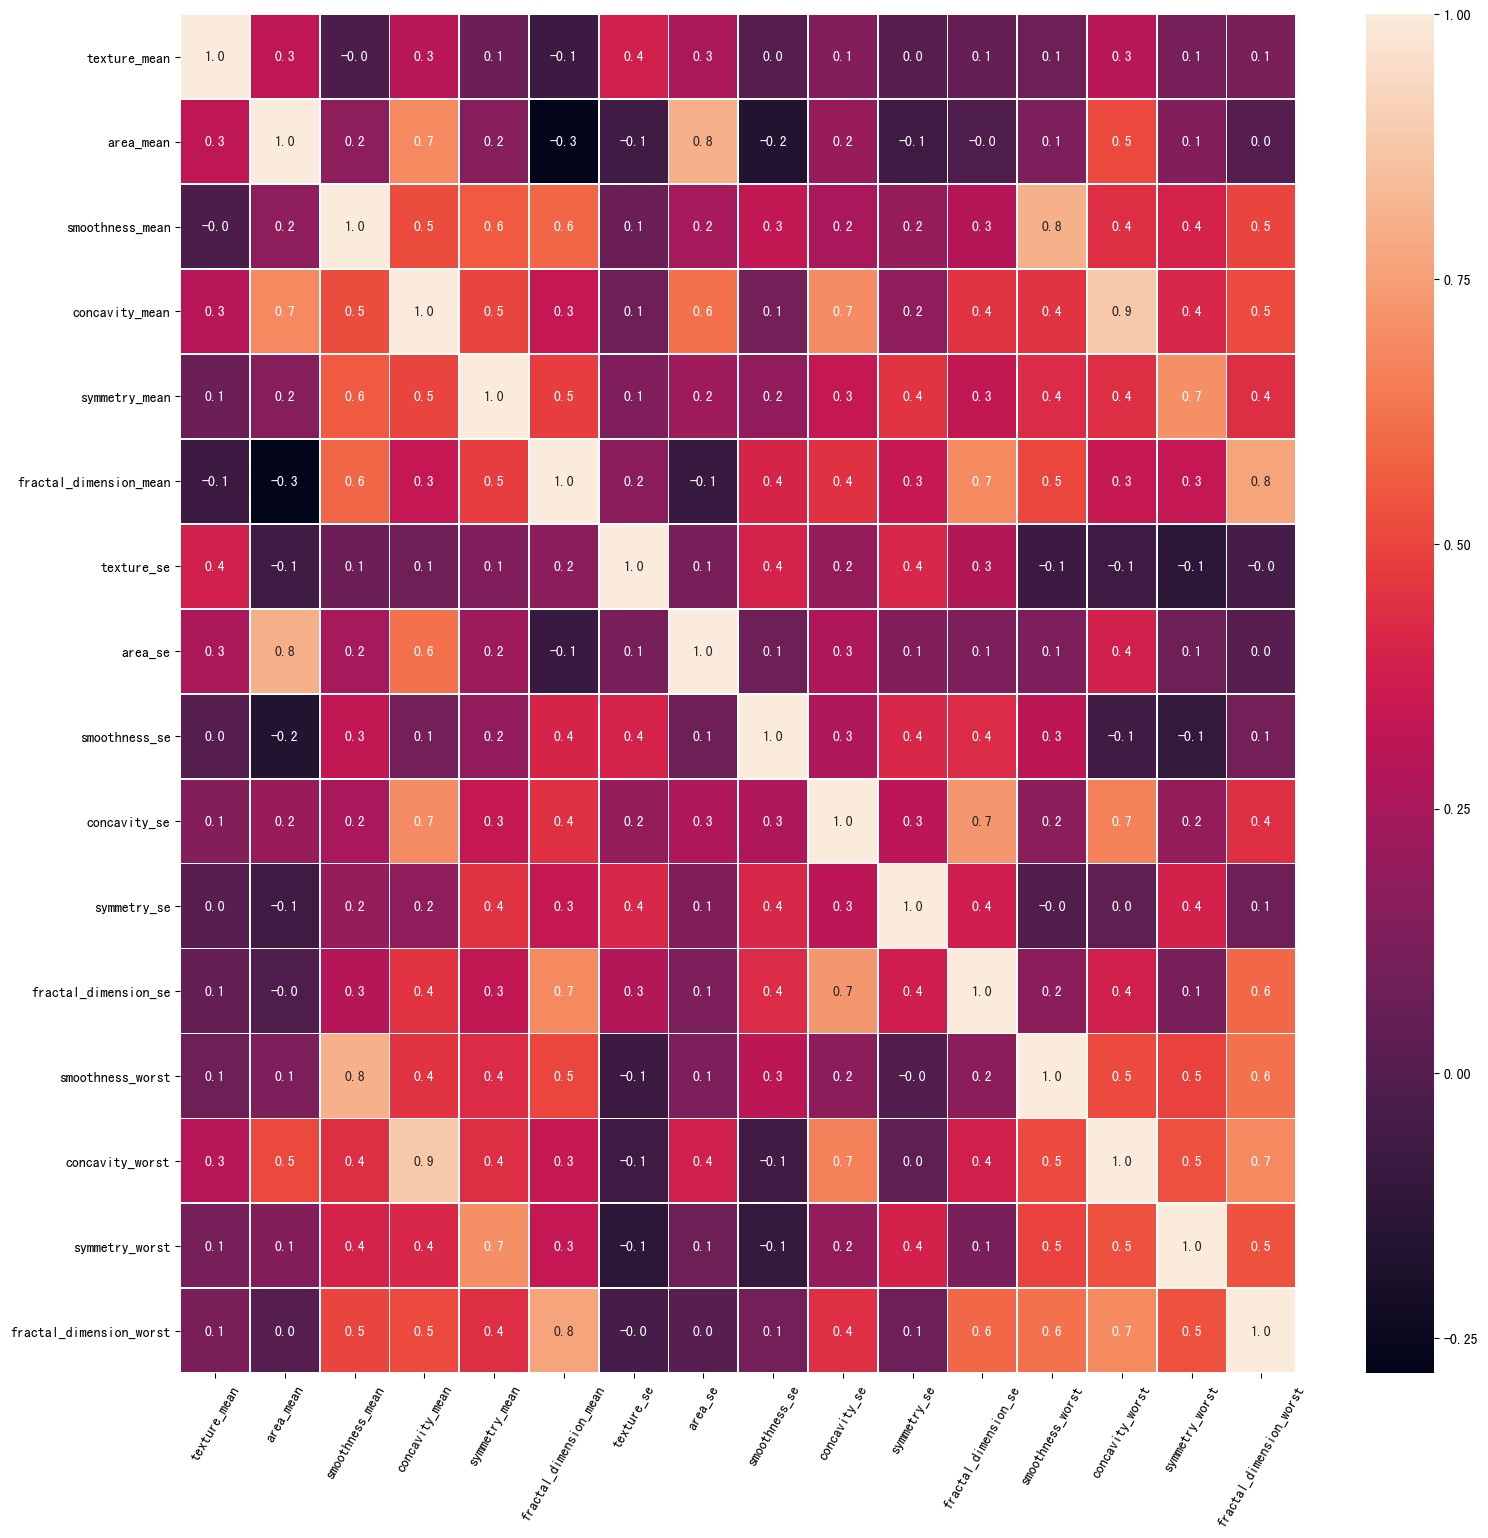

In [35]:
drop_list1 = ['perimeter_mean','radius_mean','compactness_mean','concave points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave points_worst','compactness_se','concave points_se','texture_worst','area_worst']
x_1 = X.drop(drop_list1,axis = 1 ) 
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x_1.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.xticks(rotation=60)
plt.show()

### 基于递归式特征消除的特征选择

#### 分割数据

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### 使用随机森林测试

In [37]:
rf_model = RandomForestClassifier() 
rfecv = RFECV(estimator=rf_model, step=1, cv=5,scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)

In [38]:
X_train.columns[rfecv.support_]

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'perimeter_se', 'area_se', 'concavity_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

### 训练模型

training score: 1.0
test score: 0.9298245614035088
accuracy: 0.9298245614035088
auc: 0.9344155844155844
false positive: 3, total positive: 66, false positive rate: 0.045454545454545456
false negative: 9, total negative: 105, false negative rate: 0.08571428571428572


(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 array([0.        , 0.04545455, 1.        ]),
 array([0.        , 0.91428571, 1.        ]))

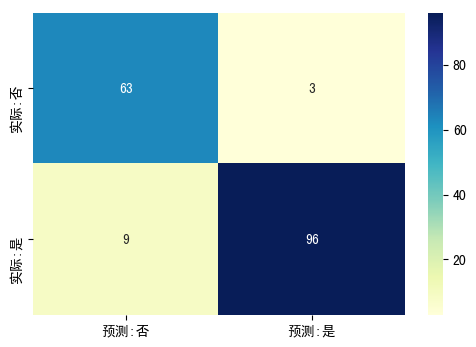

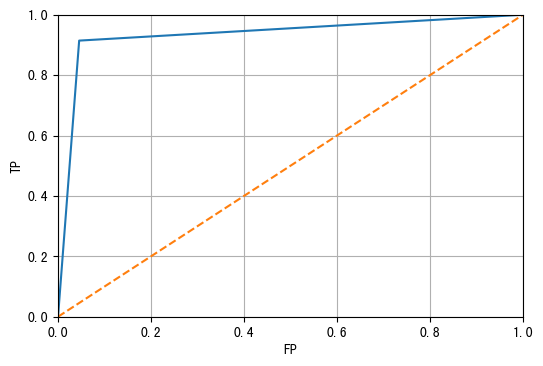

In [39]:
tree_model = DecisionTreeClassifier()
try_model(tree_model, X_train, y_train, X_test, y_test)

In [40]:
export_graphviz(tree_model, out_file='tree.dot', feature_names = X_train.columns.tolist(),
                class_names = ["恶性", "良性"],
                rounded = True, proportion = False, precision = 2, filled = True)

In [41]:
!dot -Tpng tree.dot -o tree.png -Gdpi=600

In [42]:
Image(filename = 'tree.png')

## 贷款违约预测

通过借款人及贷款信息预测其贷款违约可能性

In [43]:
field_desc_df = pd.read_excel("LCDataDictionary.xlsx", sheet_name="LoanStats")

In [44]:
field_desc = dict()
for i, r in field_desc_df.iterrows():
    field_desc[r["LoanStatNew"]] = r["Description"]

In [45]:
field_desc

{'acc_now_delinq': 'The number of accounts on which the borrower is now delinquent.',
 'acc_open_past_24mths': 'Number of trades opened in past 24 months.',
 'addr_state': 'The state provided by the borrower in the loan application',
 'all_util': 'Balance to credit limit on all trades',
 'annual_inc': 'The self-reported annual income provided by the borrower during registration.',
 'annual_inc_joint': 'The combined self-reported annual income provided by the co-borrowers during registration',
 'application_type': 'Indicates whether the loan is an individual application or a joint application with two co-borrowers',
 'avg_cur_bal': 'Average current balance of all accounts',
 'bc_open_to_buy': 'Total open to buy on revolving bankcards.',
 'bc_util': 'Ratio of total current balance to high credit/credit limit for all bankcard accounts.',
 'chargeoff_within_12_mths': 'Number of charge-offs within 12 months',
 'collection_recovery_fee': 'post charge off collection fee',
 'collections_12_mth

### 数据预处理

In [46]:
loans_df = pd.read_csv("accepted_2007_to_2018Q2.csv.gz", compression="gzip")

In [47]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004091 entries, 0 to 2004090
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.3+ GB


In [48]:
loans_df.head(5)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  38098114        NaN    15000.0      15000.0          15000.0   60 months   
1  36805548        NaN    10400.0      10400.0          10400.0   36 months   
2  37842129        NaN    21425.0      21425.0          21425.0   60 months   
3  37612354        NaN    12800.0      12800.0          12800.0   60 months   
4  37662224        NaN     7650.0       7650.0           7650.0   36 months   

   int_rate  installment grade sub_grade                        emp_title  \
0     12.39       336.64     C        C1                       MANAGEMENT   
1      6.99       321.08     A        A3   Truck Driver Delivery Personel   
2     15.59       516.36     D        D1  Programming Analysis Supervisor   
3     17.14       319.08     D        D4        Senior Sales Professional   
4     13.66       260.20     C        C3             Technical Specialist   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0  10+ years           RENT     78000.0     Source Verified  Dec-2014   
1    8 years       MORTGAGE     58000.0        Not Verified  Dec-2014   
2    6 years           RENT     63800.0     Source Verified  Dec-2014   
3  10+ years       MORTGAGE    125000.0            Verified  Dec-2014   
4   < 1 year           RENT     50000.0     Source Verified  Dec-2014   

   loan_status pymnt_plan  \
0   Fully Paid          n   
1  Charged Off          n   
2   Fully Paid          n   
3      Current          n   
4  Charged Off          n   

                                                                 url desc  \
0  https://lendingclub.com/browse/loanDetail.action?loan_id=38098114  NaN   
1  https://lendingclub.com/browse/loanDetail.action?loan_id=36805548  NaN   
2  https://lendingclub.com/browse/loanDetail.action?loan_id=37842129  NaN   
3  https://lendingclub.com/browse/loanDetail.action?loan_id=37612354  NaN   
4  https://lendingclub.com/browse/loanDetail.action?loan_id=37662224  NaN   

              purpose                    title zip_code addr_state    dti  \
0  debt_consolidation       Debt consolidation    235xx         VA  12.03   
1         credit_card  Credit card refinancing    937xx         CA  14.92   
2         credit_card  Credit card refinancing    658xx         MO  18.49   
3                 car            Car financing    953xx         CA   8.31   
4  debt_consolidation       Debt consolidation    850xx         AZ  34.81   

   delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0          0.0         Aug-1994           750.0            754.0   
1          0.0         Sep-1989           710.0            714.0   
2          0.0         Aug-2003           685.0            689.0   
3          1.0         Oct-2000           665.0            669.0   
4          0.0         Aug-2002           685.0            689.0   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0             0.0                     NaN                     NaN       6.0   
1             2.0                    42.0                     NaN      17.0   
2             0.0                    60.0                     NaN      10.0   
3             0.0                    17.0                     NaN       8.0   
4             1.0                     NaN                     NaN      11.0   

   pub_rec  revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0      0.0   138008.0        29.0       17.0                   w       0.00   
1      0.0     6133.0        31.6       36.0                   w       0.00   
2      0.0    16374.0        76.2       35.0                   w       0.00   
3      0.0     5753.0       100.9       13.0                   w    6673.54   
4      0.0    16822.0        91.9       20.0                   f       0.00   

   out_prncp_inv  total_pymnt  total_pymnt_inv  total_rec_prncp  \
0           0.00     17392.37         17392.37         15000.00   
1           0.00      6611.69         

#### 去除重复的行

In [49]:
loans_df.drop_duplicates(inplace= True)

#### 处理目标变量

In [50]:
loans_df["loan_status"].value_counts(dropna=False)

Current                                                1108697
Fully Paid                                              673112
Charged Off                                             170822
Late (31-120 days)                                       27678
In Grace Period                                          13775
Late (16-30 days)                                         7157
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     72
NaN                                                         29
Name: loan_status, dtype: int64

In [51]:
loans_df = loans_df.loc[loans_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [52]:
loans_df["loan_status"].value_counts(dropna=False)

Fully Paid     673112
Charged Off    170822
Name: loan_status, dtype: int64

In [53]:
loans_df["loan_status"] = loans_df["loan_status"].map({
    "Fully Paid": 0,
    "Charged Off": 1
})

In [54]:
loans_df["loan_status"].value_counts(normalize=True, dropna=False)

0    0.797588
1    0.202412
Name: loan_status, dtype: float64

#### 删除无用的列

In [55]:
# 删除只有一个可能值的列（这些列对样本无区分度，提供不了信息）
loans_df = loans_df.loc[:,loans_df.apply(pd.Series.nunique) != 1]

#### 删除缺失率大于等于30%的列

实际项目中可能需要用到一些算法来填充缺失值（插补）

In [56]:
missing_fractions = loans_df.isnull().mean().sort_values(ascending=False)

In [57]:
missing_fractions.head(10)

member_id                                     1.000000
next_pymnt_d                                  1.000000
orig_projected_additional_accrued_interest    0.999879
hardship_loan_status                          0.999297
hardship_reason                               0.999297
hardship_status                               0.999297
hardship_amount                               0.999297
hardship_end_date                             0.999297
payment_plan_start_date                       0.999297
hardship_dpd                                  0.999297
dtype: float64

In [58]:
drop_list = sorted(list(missing_fractions[missing_fractions >= 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_ac

In [59]:
len(drop_list)

55

In [60]:
loans_df.drop(labels=drop_list, axis=1, inplace=True)

#### 特征选择及转换（略）

In [61]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 
             'emp_length', 'fico_range_high', 'fico_range_low', 
             'home_ownership', 'initial_list_status', 'installment', 'int_rate',
             'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 
             'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util','sub_grade',
             'term', 'total_acc', 'verification_status']

In [62]:
drop_list = [col for col in loans_df.columns if col not in keep_list]
loans_df.drop(labels=drop_list, axis=1, inplace=True)

In [63]:
loans_df['term'] = loans_df['term'].apply(lambda s: np.int8(s.split()[0]))
loans_df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
loans_df['emp_length'].replace('< 1 year', '0 years', inplace=True)
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
loans_df['emp_length'] = loans_df['emp_length'].apply(emp_length_to_int)
loans_df['earliest_cr_line'] = loans_df['earliest_cr_line'].apply(lambda s: int(s[-4:]))
loans_df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)
loans_df['log_annual_inc'] = loans_df['annual_inc'].apply(lambda x: np.log10(x+1))
loans_df.drop('annual_inc', axis=1, inplace=True)
loans_df['log_revol_bal'] = loans_df['revol_bal'].apply(lambda x: np.log10(x+1))
loans_df.drop('revol_bal', axis=1, inplace=True)

In [66]:
loans_df["home_ownership"].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'OTHER'], dtype=object)

In [67]:
loans_df = pd.get_dummies(loans_df, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

In [87]:
loans_df.filter(regex="home_ownership.*").sample(5)

home_ownership_OTHER  home_ownership_OWN  home_ownership_RENT
651060                     0                   1                    0
267173                     0                   1                    0
893780                     0                   0                    1
932800                     0                   0                    0
954824                     0                   0                    1

#### 检查是否都为数字列

In [88]:
text_cols = []
for col in loans_df.columns:
    if loans_df[col].dtype == np.object:
        text_cols.append(col)
text_cols

['issue_d']

#### 数据分割

In [89]:
loans_df['issue_d'] = pd.to_datetime(loans_df['issue_d'])

Text(0.5, 1.0, '贷款样本分布')

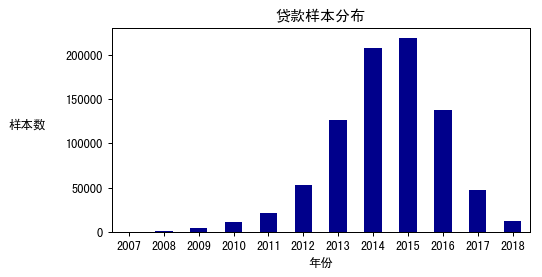

In [90]:
plt.figure(figsize=(6,3), dpi=90)
loans_df['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xticks(rotation=0)
plt.xlabel('年份')
plt.ylabel('样本数', rotation=0, labelpad=30)
plt.title('贷款样本分布')

In [91]:
loans_train = loans_df.loc[loans_df['issue_d'] < loans_df['issue_d'].quantile(0.9)]
loans_test =  loans_df.loc[loans_df['issue_d'] >= loans_df['issue_d'].quantile(0.9)]

In [92]:
loans_test.shape[0]/loans_df.shape[0]

0.10822765761303609

In [93]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

In [94]:
X_train = loans_train.drop('loan_status', axis=1)
y_train = loans_train['loan_status']
X_test = loans_test.drop('loan_status', axis=1)
y_test = loans_test['loan_status']

### 训练模型

In [95]:
linear_dep = pd.DataFrame()
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)
linear_dep["desc"] = linear_dep["variable"].map(field_desc)
linear_dep.head(20)

variable  pearson_corr  \
0                       int_rate      0.256981   
1                           term      0.185930   
2                 fico_range_low     -0.140132   
3                fico_range_high     -0.140131   
4                            dti      0.131117   
5                       mort_acc     -0.077557   
6                 log_annual_inc     -0.074319   
7                   sub_grade_A4     -0.068874   
8                     revol_util      0.066928   
9                   sub_grade_A5     -0.066150   
10           home_ownership_RENT      0.064652   
11                     loan_amnt      0.064163   
12                  sub_grade_A2     -0.062671   
13                  sub_grade_A3     -0.061853   
14                  sub_grade_E2      0.060054   
15                  sub_grade_E3      0.059895   
16                  sub_grade_E4      0.058546   
17  verification_status_Verified      0.057971   
18                  sub_grade_B1     -0.057738   
19                  sub_grade_E5      0.057642   

                                                                                                                                                                                                        desc  
0                                                                                                                                                                                  Interest Rate on the loan  
1                                                                                                                       The number of payments on the loan. Values are in months and can be either 36 or 60.  
2                                                                                                                               The lower boundary range the borrower’s FICO at loan origination belongs to.  
3                                                                                                                               The upper boundary range the borrower’s FICO at loan origination belongs to.  
4   A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.  
5                                                                                                                                                                               Number of mortgage accounts.  
6                                                                                                                                                                                                        NaN  
7                                                                                                                                                                                                        NaN  
8                                                                                 Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.  
9                                                                                                                                                                                                        NaN  
10                                                                                                                                                                                                       NaN  
11                              The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.  
12                                                                                                                                                                                                       NaN  
13                                                                         

In [96]:
print(f"annual_inc: {field_desc['annual_inc']}")
print(f"grade: {field_desc['grade']}")
print(f"home_ownership: {field_desc['home_ownership']}")

annual_inc: The self-reported annual income provided by the borrower during registration.
grade: LC assigned loan grade
home_ownership: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER


In [97]:
pipeline_rf = Pipeline([
    ("imputer", Imputer(copy=False)),
    ("model", RandomForestClassifier(n_estimators=50, n_jobs=-1))
])

training score: 0.9995482309921512
test score: 0.8526008079967593
accuracy: 0.8526008079967593
auc: 0.6759775970969694
false positive: 2864, total positive: 79443, false positive rate: 0.03605100512317007
false negative: 10599, total negative: 11894, false negative rate: 0.8911215739028081


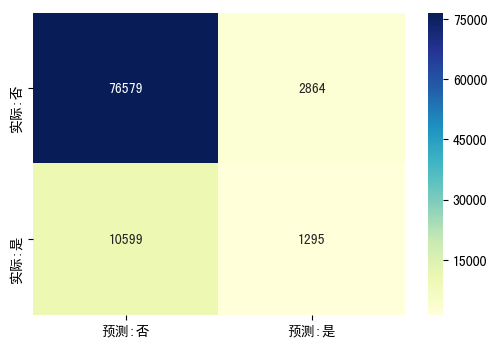

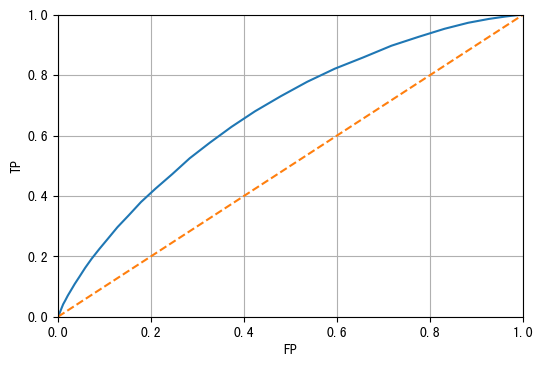

In [98]:
rf_model, rf_fpr, rf_tpr = try_model(
    pipeline_rf, X_train, y_train, X_test, y_test)

问题：
- 离群值处理
- 类不平衡问题处理（过采样、欠采样）
- 超参调优

### PS 离群值处理

In [99]:
feature_name = "dti"

In [100]:
def plot_feature_distribution(feature_values):
    fig, axes = plt.subplots(1, 3)
    # axes[0].set(xscale="log")
    # axes[1].set(yscale="log")
    axes[0].set(title="直方图")
    axes[1].set(title="累积分布函数")
    axes[2].set(title="箱形图")
    # sns.distplot(feature_values, ax=axes[0])
    # sns.distplot(feature_values, hist_kws={"cumulative": True}, kde_kws={"cumulative": True}, ax=axes[1])
    # sns.boxplot(y=feature_values, ax=axes[2])
    feature_values.dropna().hist(cumulative=False, density=1, bins=100, grid=False, ax=axes[0])
    # 从累积分布函数和箱形图可以更清楚地看到立群值
    feature_values.dropna().hist(cumulative=True, density=1, bins=100, grid=False, ax=axes[1])
    # feature_values.plot.box(grid=False, whis="range", ax=axes[2])
    feature_values.plot.box(grid=False, ax=axes[2])

    fig.tight_layout()

In [101]:
feature_values = loans_df[feature_name].dropna()
# feature_values = np.log(loans_df[feature_name].dropna())
# feature_values[feature_values == -np.inf] = 0
plot_feature_distribution(feature_values)

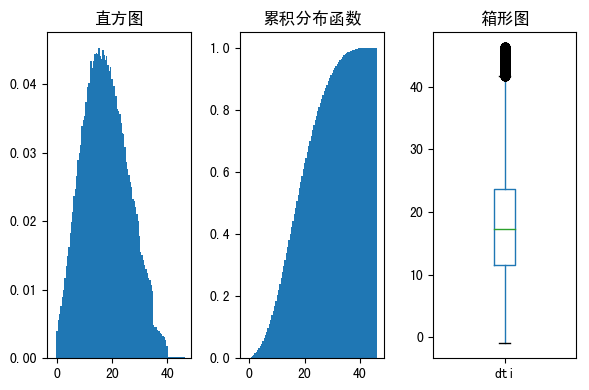

In [102]:
# feature_values = np.log(loans_df[feature_name].dropna())
# feature_values[feature_values == -np.inf] = 0
# 取[-3*std, 3*std]间的数据
feature_values = loans_df[feature_name].dropna()
feature_values = feature_values[~((feature_values-feature_values.mean()).abs() > 3*feature_values.std())]
plot_feature_distribution(feature_values)

可用用5%分位数替换小于该分位数的所有点，95%分位数替换大于该分位数的所有点

可删除所有小于${Q_1} - 1.5 \times IQR$或大于${Q_3} + 1.5 \times IQR$的值 
https://en.wikipedia.org/wiki/Interquartile_range

怎样处理离群值
https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/